# Gram-Schmidt orthogonalization

## Modified Gram-Schmidt

The classical Gram-Schmidt process is numerically unstable. A mathematically equivalent formulation, which we call MGS, which is a lot more stable numerically. 

Let $A\in\mathbb{C}^{m\times n}$ with $m\geq n$ be a full rank matrix.

Gram-Schmidt can be expressed as follows: 

$$
\mathbf{q}_1 = \frac{P_1 \mathbf{a}_1}{\|P_1\mathbf{a}_1\|},\ \mathbf{q}_2 = \frac{P_2 \mathbf{a}_2}{\|P_2\mathbf{a}_2\|}, \dots, \mathbf{q}_j = \frac{P_j \mathbf{a}_j}{\|P_j\mathbf{a}_j\|}
$$

where $P_j$ denotes a projector matrix onto $\langle \mathbf{q}_1,\dots, \mathbf{q}_{j-1}\rangle$.

In classical GS the key step is to project a new column of $A$ onto the orthogonal complement of the span of all the previous $\mathbf{q}_j$s. We express this projection as 

$$P_j=I - Q_jQ_j^*,$$ 

where $Q_j=\bigl[ \mathbf{q}_1 \mid \mathbf{q}_2\mid \cdots \mid \mathbf{q}_j\bigr]$ For example:

In [4]:
m = 6;
j = 3;
Qj = qr(rand(m,j))[1];   # get a random Q with 3 O-N columns
Pj = eye(m) - Qj*Qj';
σ = svd(Pj)[2]      # all 1 or 0, as required for an orthogonal projector

6-element Array{Float64,1}:
 1.0        
 1.0        
 1.0        
 5.88654e-16
 2.49034e-16
 1.71746e-16

We get the same result by subtracting off projections onto each column, one at a time.

In [5]:
Mj = eye(m) - Qj[:,1]*Qj[:,1]' - Qj[:,2]*Qj[:,2]' - Qj[:,3]*Qj[:,3]';
norm(Pj-Mj)

1.1102230246251565e-16

We can also write this as a product of orthogonal projectors:

In [6]:
Gj = eye(m);
for k = 1:j
    Gj = Gj*(eye(m)-Qj[:,k]*Qj[:,k]');
end
norm(Gj-Pj)

2.3344068582393236e-16

This works because the "cross-terms" you get in the products have inner products between different $\mathbf{q}_k$ and thus are zero. In MGS, we apply each of these factors, as soon at it is found, to _all_ the columns of $A$ at once. By the time we are ready to choose a new column from $A$, it is already orthgonalized against the entire ON basis set found so far.

## Operation counts

It's standard in numerical analysis to compare the performance of algorithms by counting the number of floating point operations, or flops, that are performed as a function of the input size. 

> ** THEOREM. ** By either form of QR factorization, the number of flops is $\sim 2mn^2$ in asymptotic notation, i.e. 
$$\lim_{m,n\to \infty} \frac{\# \text{flops}}{2mn^2} = 1.$$

** Proof. ** 
When $m$ and $n$ are large, the the work is dominated by:

$$
r_{ij} = \mathbf{q}_i^* \mathbf{v}_j, \quad \mathbf{v}_j = \mathbf{v}_j-r_{ij}\mathbf{q}_i.
$$

The first equation requires $m$ multiplications and $m-1$ additions.  The second requires $m$ multiplications and $m$ subtractions.  Thus the total work requires about $4m$ flops.

$$
\# \text{flops} = \sum_{i=1}^n \sum_{j=i+1}^n 4m \sim \sum_{i=1}^n (i) 4m \sim 2mn^2.
$$

elapsed time: 0.024288513 seconds
elapsed time: 0.015827882 seconds
elapsed time: 0.024764961 seconds
elapsed time: 0.037601717 seconds
elapsed time: 0.052256049 seconds
elapsed time: 0.172886537 seconds
elapsed time: 0.08946784 seconds
elapsed time: 0.110156249 seconds
elapsed time: 0.134769558 seconds
elapsed time: 0.218159947 seconds
elapsed time: 0.21395933 seconds
elapsed time: 0.347534136 seconds
elapsed time: 0.263182906 seconds
elapsed time: 0.305520892 seconds
elapsed time: 0.375287571 seconds
elapsed time: 0.426824258 seconds
elapsed time: 0.794532895 seconds
elapsed time: 0.537377079 seconds


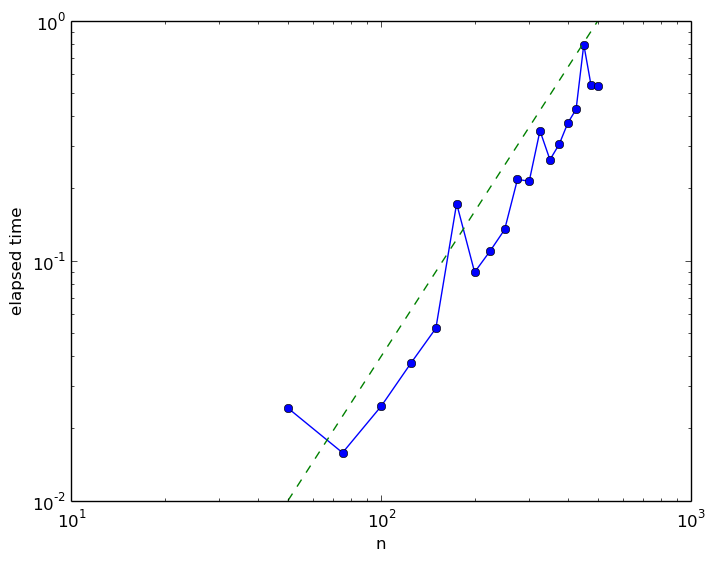

elapsed time: 0.532009197 seconds


(PyObject <matplotlib.text.Text object at 0x7fb54e33c8d0>,PyObject <matplotlib.text.Text object at 0x7fb54e388e10>)

In [11]:
n_ = collect(50:25:500);
time_ = zeros(size(n_));
for k = 1:length(n_)
    n = n_[k];
    A = rand(1200,n);
    Q = zeros(1200,n);  R = zeros(600,600); 
    
    tic();
    R[1,1] = norm(A[:,1]);
    Q[:,1] = A[:,1]/R[1,1];
    for j = 2:n
        R[1:j-1,j] = Q[:,1:j-1]'*A[:,j];
        v = A[:,j] - Q[:,1:j-1]*R[1:j-1,j];
        R[j,j] = norm(v);
        Q[:,j] = v/R[j,j];
    end
    time_[k] = toc();
end


using PyPlot
loglog(n_,time_,"-o",n_,(n_/500).^2,"--")
xlabel("n"), ylabel("elapsed time")

Flops aren't everything. On massively parallel computers, for example, the time needed for memory access and communication often competes with or dwarfs the floating point arithmetic. 

## Gram-Schmidt as Triangular Orthogonalization

The Gram-Schmidt algorithm can be viewed as multiplying $A$ on the right by a sequence of the triangular matrices:

$$
A \cdot \underbrace{R_1 R_2 \cdots R_n}_{\hat{R}^{-1}} = \hat{Q}.
$$

For instance:
$$
R_n = \begin{bmatrix} 1 & \cdots & & \\ & \ddots & & \\ & & & \frac{1}{r_{nn}}\end{bmatrix}, R_{n-1} = \begin{bmatrix} 1 & \cdots & & \\ & \ddots & & \\ & & \frac{1}{r_{(n-1)(n-1)}} & \frac{-r_{(n-1)n}}{r_{(n-1)(n-1)}} \\ & & & 1\end{bmatrix}, \dots
$$

In [28]:
m = 6;
j = 3;
A = rand(m,j);
Rj = qr(A)[2];
R = inv(Rj)
Q = A*R

6×3 Array{Float64,2}:
 -0.494323   0.555085   0.36109  
 -0.496602  -0.117899   0.0274194
 -0.509613   0.295338  -0.562796 
 -0.294441  -0.250213   0.415776 
 -0.318945  -0.597139  -0.428885 
 -0.246787  -0.414216   0.441941 

In [37]:
(Q[:,1]')*Q[:,2], (Q[:,2]')*Q[:,3], (Q[:,3]')*Q[:,1]

([-3.46945e-16],[3.60822e-16],[5.55112e-17])